In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# Load data
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
# test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
# test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# Merge datasets
df_train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
# df_test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Standardizing column names
df_train.columns = df_train.columns.str.replace('-', '_')
# df_test.columns = df_test.columns.str.replace('-', '_')

# 1. Select only numerical columns
X_train = df_train.select_dtypes(include=['number'])
# X_test = df_test.select_dtypes(include=['number'])

# 2. Handle the target variable (assuming 'isFraud' is the target)
y_train = df_train['isFraud']  # Target variable


In [7]:
correlation_matrix = df_train.corr()

# Step 2: Get the correlation of all features with the target variable ('isFraud' in this example)
target_correlation = correlation_matrix['isFraud']

top_100_features = target_correlation.abs().sort_values(ascending=False).head(100)
top_100_feature_names = top_100_features.index

# Step 5: Select the corresponding columns from the original DataFrame
df_top_100 = df_train[top_100_feature_names]

# Show the resulting DataFrame with the top 100 correlated features
print(df_top_100)

               isFraud  V257  V246  V244  V242  V201  V200  V189  V188  V258  \
TransactionID                                                                  
2987000              0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2987001              0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2987002              0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2987003              0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2987004              0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
...                ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3577535              0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3577536              0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3577537              0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3577538              0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3577539              0   NaN   NaN   NaN

In [9]:
# Reduce memory usage
df_train = reduce_mem_usage(df_train)

start_mem Memory usage of df_train: 1955.37 MB
Mem. usage decreased to 527.70 Mb (73.0% reduction)


In [10]:
for f in df_train.drop('isFraud', axis=1).columns:
     if df_train[f].dtype=='object': 
         lbl = LabelEncoder()
         lbl.fit(df_train[f].values)
         df_train[f] = lbl.transform(list(df_train[f].values))

df_train.fillna(-999, inplace=True)

X_train = df_train.select_dtypes(include=['number']).drop(columns=['isFraud'])
y_train = df_train['isFraud']  # This is the target variable

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Apply StandardScaler (fit only on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA and specify number of components (optional)
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


Accuracy with k=5: 0.9715
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.72      0.31      0.43      4133

    accuracy                           0.97    118108
   macro avg       0.85      0.65      0.71    118108
weighted avg       0.97      0.97      0.97    118108



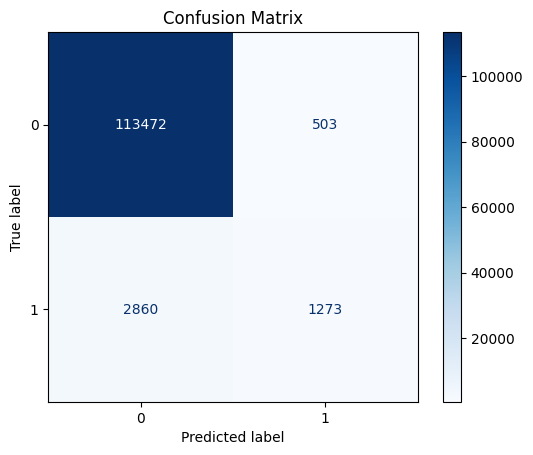

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_pca, y_train_final)
y_val_pred = knn.predict(X_val_pca)

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy with k={5}: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix (useful for imbalanced classes like fraud detection)
cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues')  # 'Blues' colormap for better readability
plt.title('Confusion Matrix')
plt.show()